In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

## More classification, K-nearest neighbors, and Decision Trees

We've looked at logistic regression as an approach to a binary classification problem.

Given observations (Say, a student's GPA and MCAT score) and class labels (Did the student get admitted to medical school?), we buit a model that was linear in the log odds:

Let $p$ be the probability that an observation is in class 1:
$$
\log(\text{odds})=\log(\frac{p}{1-p}) =\beta_0+\beta_1(GPA)+\beta_2(MCAT)
$$

Then, we exponentiate (and manipulate) to get:
$$
p(X=1)=\frac{e^{\beta_0+\beta_1(GPA)+\beta_2(MCAT)}}{1+e^{\beta_0+\beta_1(GPA)+\beta_2(MCAT)}}
$$

When $p=0.5$, log(odds) = 0, we we see the linear decision boundary above. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
med=pd.read_csv('/content/drive/MyDrive/Data 599/MedGPA.csv')
med.head()

,Accept,Acceptance,Sex,GPA,MCAT,Apps
0,D,0,F,3.62,38,5
1,A,1,M,3.84,45,3
2,A,1,F,3.23,33,19
3,A,1,F,3.69,40,5
4,A,1,F,3.38,35,11


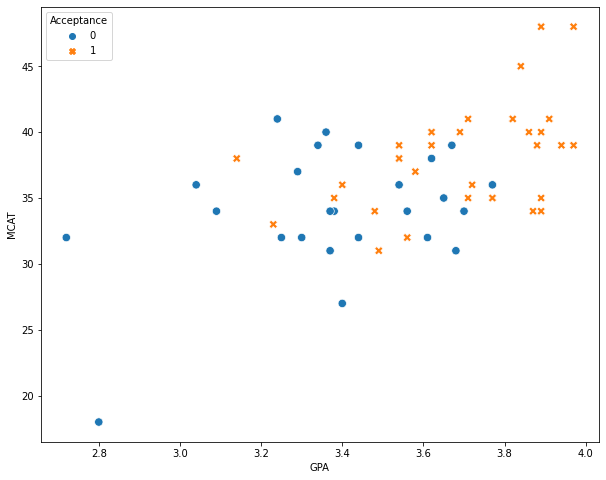

In [6]:
plt.figure(figsize = (10,8))
sns.scatterplot(data=med, x="GPA", y="MCAT",hue='Acceptance',style='Acceptance',s=70)
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
X = med[['GPA','MCAT']]
y=med['Acceptance']

In [9]:
med_clf = LogisticRegression(random_state=0,penalty='none').fit(X, y)

Gives us coeficients of the predictor variables (GPA and MCAT) and the intercept:

In [10]:
print(med_clf.coef_,med_clf.intercept_)

[[4.67660734 0.16449948]] [-22.37318235]


Beacuse the lgostic regression model predicts a probability, there's some flexibility regarding where we put the probability threshold (0.5 is default). We can visualie the linear decision boundary)
$$
\log(\text{odds})= 0 =\beta_0+\beta_1(GPA)+\beta_2(MCAT)
$$

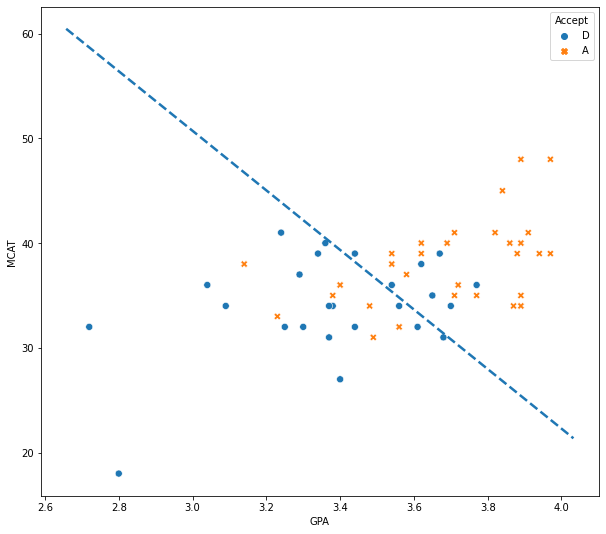

In [11]:
b=med_clf.intercept_
b1=med_clf.coef_[0][0]
b2=med_clf.coef_[0][1]

f, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(x="GPA", y="MCAT",
                hue="Accept", style="Accept",
                data=med,s=50, ax=ax)
x_vals = np.array(ax.get_xlim())
y_vals = -b/b2 - (b1/b2) * x_vals
plt.plot(x_vals, y_vals, '--',linewidth=2.5)
# Note, we can change the predition threshold so as to make it easier (or harder) to predict class 1: 
#y_vals2 = -(b+np.log(.45/.55))/b2 - (b1/b2) * x_vals
#plt.plot(x_vals, y_vals2, '--',linewidth=2.5)
plt.show()

To get more flexible decision boundaries, we can assume more flexible models on the log odds (introduce squares or cubes of predictors, etc.).

Ultimately, we test our model by considering it's accuracy (percentage of correct predictions) on test data.

But what if we have more than two classes? Or it's unreasonable to expect a particular form (linear, quadratic, etc.) for the decision boundary?

For example, maybe we want to know if a student was admitted to an elite medical school, a tier two school, or a tier three school? Or maybe we want to classify basketball payers as G,F,C? Or some more interesting set of positions (like point forward, etc.)

These are examples of ***multi-class*** classification problems.

While there are extensions of logistic regression to multiclass problems, they aren't used much in practice as they suffer from some numerical issues.

We are going to look at one of the most widely used and simplest ML classification methods. It generalizes to multi-class problems and allows for flexible decision boundaries.

 ### k-nearest neighbors

This classifier makes **NO** assumptions. It simply needs a notion of distance. Given training data (labeled observations), and an observation to be classified, *knn* looks at the $k-$nearest neighbors and let's them vote (majority rule) on the class.

Here's a picture with $k=3$:

<img src="knn_pic.png">

*Image from ISLR: James, Witten, Hastie, Tibshirani*

Note: $knn$ doesn't even fit a model. The model is just the labeled training data.

### One big obvious question... 

How to choose $k$? First, different choices of $k$ can make a dramatic difference in results. 

Let's do a toy example (so we can draw pictures) and then some real examples.

In [12]:
np.random.seed(1)
mX,my = datasets.make_moons(n_samples=500)
jig=np.random.normal(0,.2,size=[500,2])

mdf=pd.DataFrame(mX+jig,columns=['feat1','feat2'])
mdf['Class']=my
mdf.head()

,feat1,feat2,Class
0,0.409860,0.030967,1
1,0.903431,-0.555821,1
2,0.914180,0.574279,0
3,0.447570,0.520823,0
4,2.109126,0.026856,1


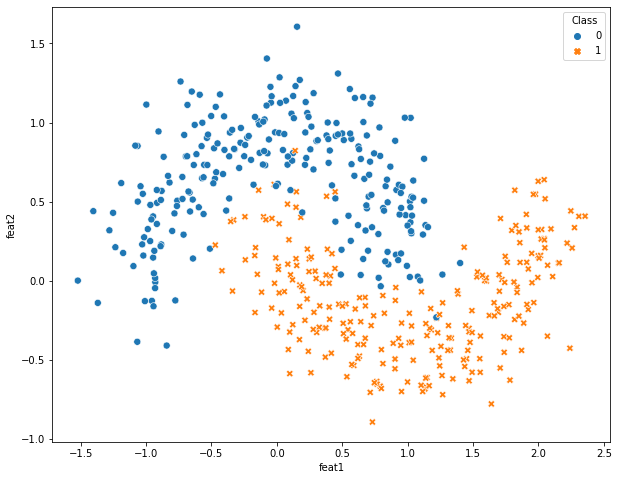

In [13]:
plt.figure(figsize = (10,8))
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=mdf,s=50)
xlim_range=plt.gca().get_xlim()
ylim_range=plt.gca().get_ylim()
plt.show()

Let's fit a knn model with $k=1$ and plot the decision boundary.

As usual, split into train and test sets: 

In [14]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(mdf[['feat1','feat2']], mdf['Class'], test_size=0.3, random_state=5)

Specify the model method including the number of neighbors to use. Then, fit on the training data.

In [15]:
clf = KNeighborsClassifier(n_neighbors=1)
nb1=clf.fit(Xn_train[['feat1','feat2']],yn_train)

Now draw the decision boundary -- make a grid of points and predict the class using the nearest neighbor.

In [16]:
xx, yy = np.meshgrid(np.linspace(xlim_range[0], xlim_range[1], 500), np.linspace(ylim_range[0], ylim_range[1], 500))
X_grid = np.c_[xx.ravel(), yy.ravel()]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


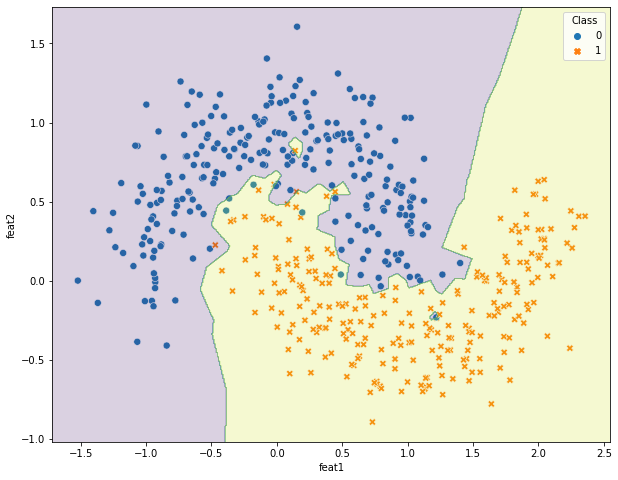

In [17]:
zz_nn = nb1.predict_proba(X_grid)[:,1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=mdf,s=50)
plt.contourf(xx, yy, zz_nn > 0.5, alpha=0.2)
plt.show()

Note: Very flexible decision boundary! Even have "islands".

Check accuracy on test set:

In [18]:
accuracy_score(nb1.predict(Xn_test),yn_test)

0.9533333333333334

Note:

In [19]:
accuracy_score(nb1.predict(Xn_train),yn_train)

1.0

^^ That makes sense... right? Why?

We can make a much smoother decision boundary by increasing $k$. Balance overfitting (variance) with bias. 

In [20]:
clf20 = KNeighborsClassifier(n_neighbors=20)
nb20=clf20.fit(Xn_train[['feat1','feat2']],yn_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


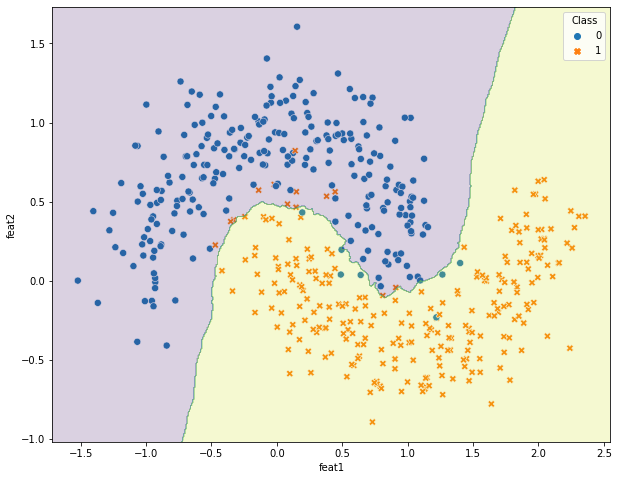

In [21]:
zz_nn20 = nb20.predict_proba(X_grid)[:,1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=mdf,s=50)
plt.contourf(xx, yy, zz_nn20 > 0.5, alpha=0.2)
plt.show()

How to choose the optimal $k$? Cross validation.

In [22]:
#Create a list to store the results
cvres=[]
# Run through various values for k: use 5-fold cross validation, score with accuracy
for i in range(1,100):
    clf = KNeighborsClassifier(n_neighbors=i)
    nn = cross_validate(clf, Xn_train, yn_train, cv=5, scoring='accuracy')
    #The test score gives an list of the accuracy on each of the five the test-folds
    cvres.append(nn['test_score'].mean())

In [23]:
nn['test_score']

array([0.88571429, 0.9       , 0.87142857, 0.9       , 0.91428571])

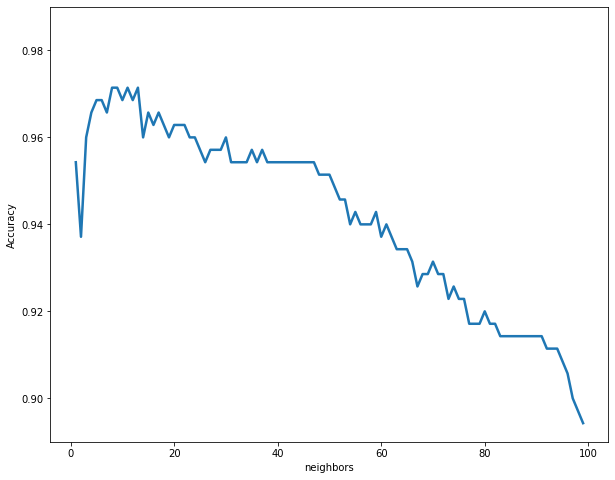

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(list(range(1,100)),cvres,linewidth=2.5)
plt.ylim(.89,.99)
plt.xlabel('neighbors')
plt.ylabel('Accuracy')
plt.show()

In [25]:
np.argmax(cvres)

7

Looks like best results when $k=8$.

In [26]:
cvres[0:10]

[0.9542857142857143,
 0.9371428571428572,
 0.96,
 0.9657142857142856,
 0.9685714285714286,
 0.9685714285714286,
 0.9657142857142859,
 0.9714285714285715,
 0.9714285714285715,
 0.9685714285714286]

In [27]:
mod = KNeighborsClassifier(n_neighbors=8)
nb8=mod.fit(Xn_train[['feat1','feat2']],yn_train)

In [28]:
np.round(accuracy_score(nb8.predict(Xn_test),yn_test),3)

0.973

For $KNN$ to be appropriate (work well) there are some assumptions: 

1. Observations near one another should be similar! (Maybe that's true... but if both my neighbors love French arthouse movies... well, maybe not.)

2. Distance makes sense! Categorical variables are problematic. 

3. Variables should be scaled since large values can skew distance!

But, *knn* also works nicely for multi-class problems!

In [29]:
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=200,centers=4,random_state=2,cluster_std=2)

This is a toy dataset with 4 classes of points in the $xy$-plane

In [30]:
df=pd.DataFrame(X,columns=['feat1','feat2'])
df['Class']=y

In [31]:
df.head()

,feat1,feat2,Class
0,-6.324435,2.660655,3
1,0.369304,-6.985050,0
2,0.440891,-2.327320,1
3,-6.341449,-3.276264,2
4,7.552740,0.648170,1


Let's plot them and get the range of values on the $x$ and $y$-axes.

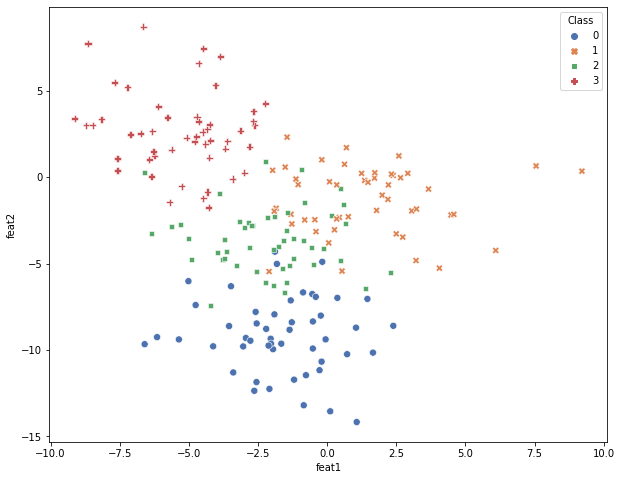

In [32]:
plt.figure(figsize = (10,8))
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',palette="deep",data=df,s=50)
#gca() gets the current axes
xlims=plt.gca().get_xlim()
ylims=plt.gca().get_ylim()
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df[['feat1','feat2']], df['Class'], test_size=0.3, random_state=1)

Let's look at a few of the possible decision boundaries.

In [34]:
model1= KNeighborsClassifier(n_neighbors=1).fit(X_train[['feat1','feat2']],y_train)
model3= KNeighborsClassifier(n_neighbors=3).fit(X_train[['feat1','feat2']],y_train)
model10= KNeighborsClassifier(n_neighbors=10).fit(X_train[['feat1','feat2']],y_train)

In [35]:
from matplotlib.colors import ListedColormap

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


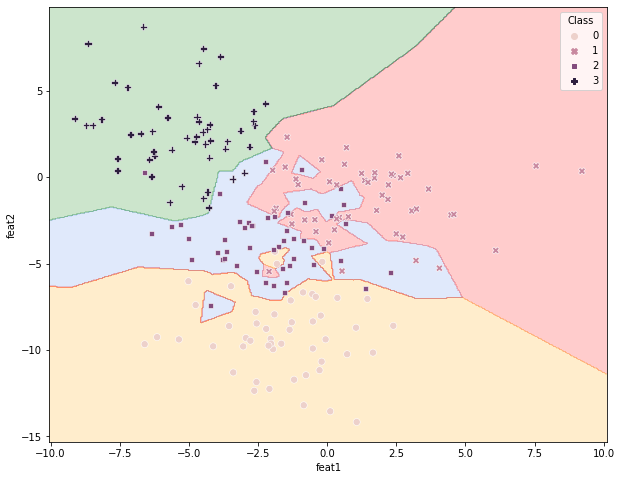

In [36]:
cmap_light = ListedColormap(['orange', 'red', 'cornflowerblue','green'])
xx, yy = np.meshgrid(np.linspace(xlims[0], xlims[1], 500), np.linspace(ylims[0], ylims[1], 500))
X_grid = np.c_[xx.ravel(), yy.ravel()]
Z=model1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z ,cmap=cmap_light,alpha=0.2)
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=df,s=50)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


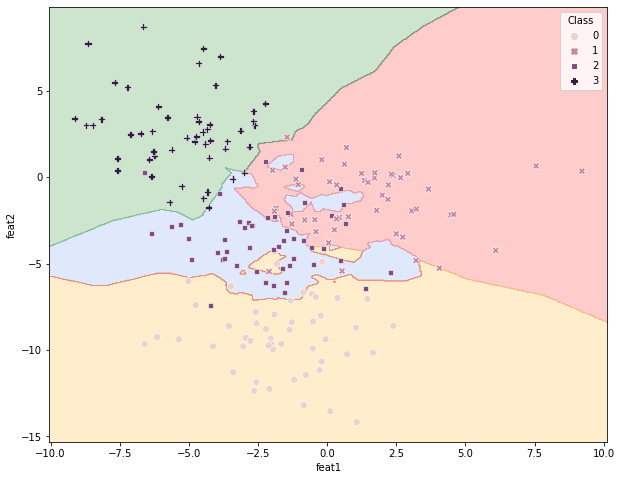

In [37]:
Z=model3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z ,cmap=cmap_light,alpha=0.2)
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=df,s=50)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


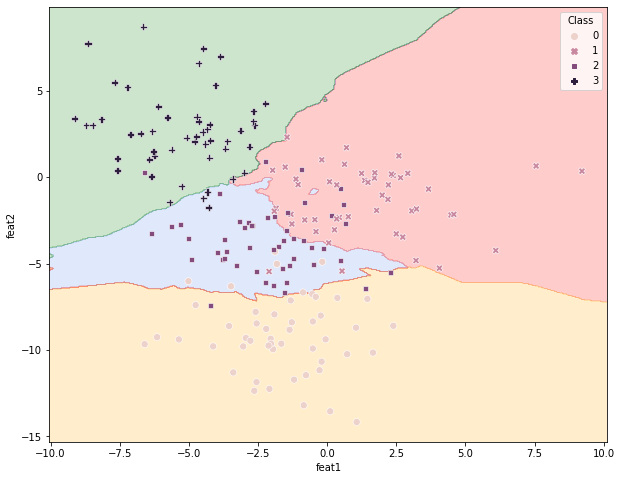

In [38]:
Z=model10.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z ,cmap=cmap_light,alpha=0.2)
sns.scatterplot(x='feat1',y='feat2',hue='Class',style='Class',data=df,s=50)
plt.show()

In [39]:
y

array([3, 0, 1, 2, 1, 3, 3, 2, 1, 1, 0, 1, 0, 3, 3, 2, 1, 3, 0, 2, 1, 3,
       1, 1, 1, 2, 2, 2, 1, 3, 0, 3, 2, 3, 2, 0, 0, 2, 3, 0, 0, 2, 2, 2,
       3, 0, 0, 3, 2, 2, 0, 2, 0, 2, 1, 2, 0, 1, 3, 2, 3, 3, 1, 2, 1, 2,
       0, 0, 3, 1, 3, 1, 1, 1, 2, 3, 3, 0, 1, 1, 2, 0, 3, 3, 1, 1, 2, 0,
       2, 2, 1, 0, 2, 0, 1, 3, 1, 1, 3, 2, 1, 0, 0, 0, 3, 2, 2, 3, 3, 0,
       1, 2, 2, 0, 1, 2, 0, 3, 0, 0, 2, 0, 0, 3, 2, 2, 1, 1, 3, 2, 1, 1,
       3, 3, 2, 1, 0, 2, 0, 3, 0, 1, 1, 3, 3, 0, 3, 2, 0, 1, 0, 0, 3, 3,
       1, 3, 3, 0, 0, 2, 1, 1, 3, 3, 0, 1, 2, 2, 3, 1, 0, 2, 3, 1, 1, 3,
       2, 0, 0, 0, 1, 1, 3, 3, 1, 3, 1, 2, 0, 3, 2, 1, 0, 2, 0, 0, 2, 3,
       0, 2])

In [40]:
mc_cvres=[]
# Run through various values for k: use 5-fold cross validation, score with accuracy
for i in range(1,31):
    mclf = KNeighborsClassifier(n_neighbors=i)
    mc_nn = cross_validate(mclf, X_train, y_train, cv=5, scoring='accuracy')
    #The test score gives an list of the accuracy on each of the five the test-folds
    mc_cvres.append(mc_nn['test_score'].mean())

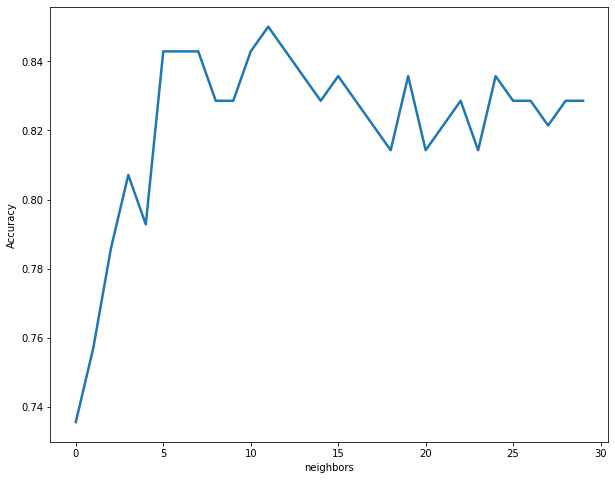

In [41]:
plt.figure(figsize=(10, 8))
plt.plot(list(range(len(mc_cvres))),mc_cvres,linewidth=2.5)
plt.xlabel('neighbors')
plt.ylabel('Accuracy')
plt.show()

In [42]:
np.argmax(mc_cvres)

11

###### Now try for real data

In [43]:
bcd = datasets.load_breast_cancer()
df = pd.DataFrame(bcd['data'], columns=bcd['feature_names'])
df['target'] = bcd['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


This data set has lots of medical measurements. The target is the presence (1) or absence of breast cancer (0).

In [44]:
df.shape

(569, 31)

Check for missing data:

In [45]:
df.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

Check for categorical data: Remember that distance needs to make sense.

In [46]:
df.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [47]:
X=df.drop('target',axis=1)
y=df['target']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

### Scale!

First scale the data: replace each entry $x$ in a column with
$$
\frac{x-\mu_{\text{col}}}{\sigma_{\text{col}}}
$$

Then each column will have mean 0 and standard deviation 1.

To see what can happen if we don't do this, recall the Med School data from above:

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


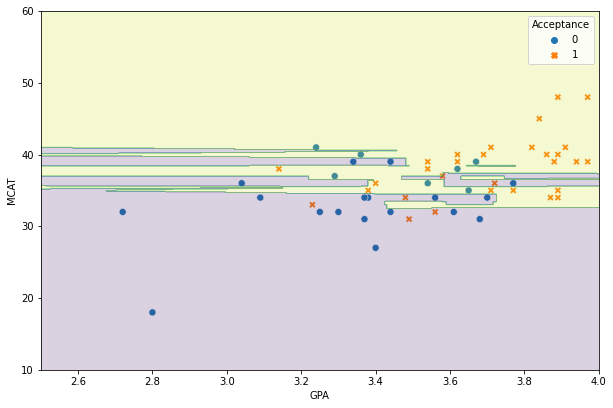

In [49]:
mclf = KNeighborsClassifier(n_neighbors=3)
m3=mclf.fit(med[['GPA','MCAT']],med['Acceptance'])
mxx, myy = np.meshgrid(np.linspace(2.5, 4, 500), np.linspace(10, 60, 500))
mX_grid = np.c_[mxx.ravel(), myy.ravel()]
mzz_nn = m3.predict_proba(mX_grid)[:,1].reshape(mxx.shape)
f, ax = plt.subplots(figsize=(10, 6.6))
sns.scatterplot(x='GPA',y='MCAT',hue='Acceptance',style='Acceptance',data=med,s=50)
plt.contourf(mxx, myy, mzz_nn > 0.5, alpha=0.2)
plt.show()

See how the neighborhoods are distorted by the fact that $x$-axis values are much smaller than $y$-axis values because GPA and MCAT score are measured on different scales. It's much easier for points along similar horizontal lines to be "closer" together.

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

check: columns have mean 0 and std 1?

In [52]:
np.allclose(np.mean(X_train_scaled,axis=0),0),np.allclose(np.std(X_train_scaled,axis=0),1)

(True, True)

In [53]:
cvres=[]
for i in range(1,20):
    clf = KNeighborsClassifier(n_neighbors=i)
    nn = cross_validate(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cvres.append(nn['test_score'].mean())

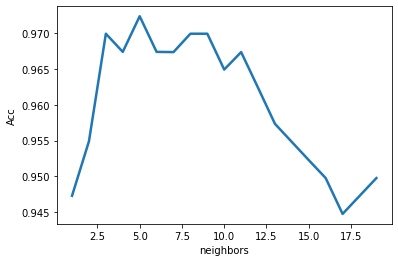

In [54]:
plt.plot(list(range(1,20)),cvres[0:19],linewidth=2.5)
plt.xlabel('neighbors')
plt.ylabel('Acc')
plt.show()

Max at k=5

In [55]:
mod = KNeighborsClassifier(n_neighbors=5)
nb5=mod.fit(X_train_scaled,y_train)

In [56]:
accuracy_score(nb5.predict(X_test_scaled),y_test)

0.9590643274853801

Scaling helps:

In [57]:
badmod = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)

In [58]:
accuracy_score(badmod.predict(X_test),y_test)

0.9473684210526315

$KNN$ is easy, flexible, intuitive, and pretty good. But limited. (How to handle categorical features, for example? Trouble in high dimensions or really big data.)

***KNN*** can be used for regression too: Take $k$-nearest neighbors and average their $y$-value. We'll do an example below.

## Trees

#### Tree based methods apply to both regression and classification--  start with regression.

Let's look at NBA player salaries (with some stats) between 1985 and 2018.

In [59]:
pl=pd.read_csv('players.csv')
sal=pd.read_csv('salaries_1985to2018.csv')

FileNotFoundError: ignored

In [ ]:
pl.columns

In [ ]:
pl.head()

In [ ]:
sal.head()

We can immediately see that players have different salaries over different seasons. Let's use mean salary together with career stats.

In [ ]:
fig = plt.subplots(1,figsize=(10, 8))
p1=sns.barplot(x="season_end", y="salary",data=sal)
p1.set(xticklabels=[]) 
plt.show()

In [ ]:
gp_sal=sal[['player_id','salary']].groupby('player_id',as_index=False).mean()

In [ ]:
gp_sal.head()

In [ ]:
players=pl.merge(gp_sal,how='left',left_on='_id',right_on='player_id')

In [ ]:
players.head()

Looks good but there is some missing data.

In [ ]:
players[players.salary.isnull()].head()

Looks like mostly older data so let's drop NaNs.

In [ ]:
players=players[players['salary'].notnull()]

Is Steph in here?

In [ ]:
players[players['name']=="Stephen Curry"]

Yes! Let's predict (log) salary based on available features.

In [ ]:
from sklearn import tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

First let's play around with just a couple of features:

In [ ]:
ex_data=players[['career_PTS','career_G','salary']].copy()

Let's take logs of variables that can get really big.

In [ ]:
ex_data['salary'].hist(bins=30)

In [ ]:
ex_data['logsalary']=np.log(ex_data['salary'])
ex_data['logG']=np.log(ex_data['career_G'])

In [ ]:
ex_data['logsalary'].hist(bins=30)

In [ ]:
ex_data.isnull().sum()

Good to go!

In [ ]:
Xe=ex_data[['career_PTS','logG']]
ye=ex_data['logsalary']

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='career_PTS',y='logG',data=ex_data)
plt.show()

Each dot has a salary -- think of as a height above the point or use color.

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='career_PTS',y='logG',data=ex_data,hue='logsalary')
plt.show()

Idea of a decision tree: Divide the predictor space up into non-overlapping regions $R_1,\ldots, R_n$.

Then predict the same value for all points in a given region $R_i$: use mean of all values in $R_i$: average log salary, eg.

This is complicated in that there are WAY TOO MANY possible regions. We simplify:

* Use rectangles
* Pick a predictor $X_j$. For each value $s$ of $X_j$, compute $RSS$ using ($X_j < s$) and ($X_j > s$) 
* Pick the predictor and cutpoint having the lowest $RSS$.
* Now repeat within previously defined regions.

The rectangular regions at the end are called *terminal nodes* or *leaves*.

Example

In [ ]:
eregr = DecisionTreeRegressor(max_depth=2).fit(Xe,ye)

In [ ]:
from sklearn.tree import export_text

In [ ]:
ex_data.columns

In [ ]:
r = export_text(eregr,feature_names=list(Xe.columns))
print(r)

In [ ]:
eregr.get_depth()

In [ ]:
eregr3 = DecisionTreeRegressor(max_depth=3).fit(Xe,ye)
r3=export_text(eregr3,feature_names=list(Xe.columns))
print(r3)

Visual aid on the depth 2 tree:

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='career_PTS',y='logG',data=ex_data)
plt.hlines(y=4.9, xmin=0, xmax=30, colors='black', ls='--', lw=3)
plt.hlines(y=3.24, xmin=0, xmax=30, colors='black', ls='--', lw=3)
plt.vlines(x=9.05, ymin=4.9, ymax=7.5, colors='black', ls='--', lw=3)

Let's work on the full data set

In [ ]:
players['logsalary']=np.log(players['salary'])
players['logG'] =np.log(players['career_G'])

In [ ]:
players.columns

Let's use columns that seem relevant and drop some that don't.

In [ ]:
pdf=players[['career_AST', 'career_FG%','career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS','career_TRB', 'career_WS', 'career_eFG%',
       'logsalary', 'logG']].copy()

Some of these features need to be converted to numerical.

In [ ]:
pdf.dtypes

In [ ]:
pdf['career_FG%']=pd.to_numeric(pdf['career_FG%'],errors='coerce')
pdf['career_FG3%']=pd.to_numeric(pdf['career_FG3%'],errors='coerce')
pdf['career_FT%']=pd.to_numeric(pdf['career_FT%'],errors='coerce')
pdf['career_PER']=pd.to_numeric(pdf['career_PER'],errors='coerce')
pdf['career_TRB']=pd.to_numeric(pdf['career_TRB'],errors='coerce')
pdf['career_WS']=pd.to_numeric(pdf['career_WS'],errors='coerce')
pdf['career_eFG%']=pd.to_numeric(pdf['career_eFG%'],errors='coerce')

In [ ]:
pdf.isnull().sum()

As before, drop nans.

In [ ]:
pdf=pdf.dropna()

In [ ]:
X=pdf.drop('logsalary',axis=1)
y=pdf['logsalary']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

In [ ]:
X.dtypes

In [ ]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_5 = DecisionTreeRegressor(max_depth=5)
full_tree = DecisionTreeRegressor()
regr_1.fit(X_train, y_train)
regr_5.fit(X_train, y_train)
full_tree.fit(X_train, y_train)

In [ ]:
full_tree.get_depth()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(full_tree.predict(X_train), y_train)

But, we're quite sure this is overfit and won't generalize well.

In [ ]:
mean_squared_error(regr_5.predict(X_train), y_train)

In [ ]:
mean_squared_error(regr_1.predict(X_train), y_train)

On the test set:

In [ ]:
print("full",mean_squared_error(full_tree.predict(X_test), y_test),":","depth5",mean_squared_error(regr_5.predict(X_test), y_test),":","depth2",mean_squared_error(regr_1.predict(X_test), y_test))

Good example of overfitting!!

Deep trees are prone to overfitting and poor generalization.

We can also use $R^2$ on test set as metric if we prefer

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(regr_5.predict(X_test),y_test)

We can also draw the decision tree but this gets messy quickly:

In [ ]:
plt.figure(figsize=(10, 8))
tree.plot_tree(regr_1,feature_names=list(X.columns))
plt.show()

In [ ]:
print("left terminal node",np.round(np.exp(12.111),2),":","right terminal node",np.round(np.exp(15.268),2))

Feature importances help us understand which variables are responsible for the largest reductions in $MSE$.  

In [ ]:
regr_5.feature_importances_

In [ ]:
nfeat=X.shape[1]
plt.barh(np.arange(nfeat),regr_5.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(X.columns))
plt.ylim(-1,nfeat)

How to control for overfitting? One option is to set max depth or stop adding branches if $RSS$ reduction isn't large enough. However, this can miss good cuts coming later on.

Preferred: Build a deep tree and prune it back.

One method to do this is called *cost complexity pruning*. It borrows an idea from Ridge Regression.

Given a deep tree $T$, and parameter $\alpha$ find a subtree that minimizes:
$$
\sum_{m=1}^{|T|}\sum_{x_i\in R_m}(y_i-\hat{y}_{R_m})^2 +\alpha|T|
$$
where $|T|$ is the number of terminal nodes in the tree.

So, add a penalty for complex (deep) trees.

Then we can use cross validation to select the optimal $\alpha$.

In [ ]:
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
path

In [ ]:
ccp_alphas

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
#ax.plot(ccp_alphas[:], impurities[:], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total MSE of leaves")
ax.set_title("Total MSE vs effective alpha for training set")
plt.show()

In [ ]:
len(ccp_alphas)

In [ ]:
regs = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    regs.append(reg)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regs[-1].tree_.node_count, ccp_alphas[-1]))

In [ ]:
regs = regs[:-1]
ccp_alphas = ccp_alphas[:-1]

In [ ]:
len(regs)

In [ ]:
ccp_alphas[0:3]

In [ ]:
len(ccp_alphas)

In [ ]:
node_counts = [reg.tree_.node_count for reg in regs]

In [ ]:
len(node_counts)

In [ ]:
node_counts = [reg.tree_.node_count for reg in regs]
depth = [reg.tree_.max_depth for reg in regs]
fig, ax = plt.subplots(2, 1,figsize=(9,9))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
train_scores = [reg.score(X_train, y_train) for reg in regs]
test_scores = [reg.score(X_test, y_test) for reg in regs]

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("alpha")
ax.set_ylabel("R^2")
ax.set_title("R^2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
train_scores = [mean_squared_error(reg.predict(X_train), y_train) for reg in regs]
test_scores = [mean_squared_error(reg.predict(X_test),y_test) for reg in regs]

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
ccp_alphas[0:10]

This takes a while-- be careful!

In [ ]:
cvres=[]
for a in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha= a)
    cvreg = cross_validate(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cvres.append(cvreg['test_score'].mean())

In [ ]:
np.argmax(cvres)

In [ ]:
regO = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alphas[1402]).fit(X_train,y_train)

In [ ]:
ccp_alphas[1402]

In [ ]:
regO.get_depth()

In [ ]:
regO.score(X_test,y_test)

In [ ]:
full_tree.score(X_test,y_test)

In [ ]:
mean_squared_error(regO.predict(X_test),y_test)

In [ ]:
mean_squared_error(full_tree.predict(X_test),y_test)

#### Decision Tree Classifiers

Very similar! The only real difference is that we can't use $RSS$ or $MSE$ to determine the cut points. 

Essentially, we need a definition of error in a rectangular region. We will assign all points in $R_i$ to the most common class in $R_i$. So, it would seem natural to use the fraction of observations *not* in that most common class. 

$$
1-\max_{k}(\hat{p}_{mk})
$$

This turns out to be not quite sensitive enough to decide cuts. Rather we use the Gini-index:

$$
G=\sum_{k} \hat{p}_{mk}(1-\hat{p}_{mk})
$$

G is small when all classes are near $0$ or $1$.

In [ ]:
db=pd.read_csv('diabetes.csv')
db.head()

In [ ]:
db.shape

In [ ]:
db.dtypes

In [ ]:
db.isna().sum()

In [ ]:
db['Outcome'].head()

In [ ]:
X=db.drop('Outcome',axis=1)
y=db['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [ ]:
X_train.shape

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
ccp_alphas

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

In [ ]:
cvres=[]
for a in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha= a)
    cvclf = cross_validate(clf, X_train, y_train, cv=5, scoring='accuracy')
    cvres.append(cvclf['test_score'].mean())

In [ ]:
len(cvres)

In [ ]:
plt.plot(list(range(1,55)),cvres,linewidth=2.5)
plt.xlabel('indx')
plt.ylabel('Acc')
plt.show()

In [ ]:
np.argmax(cvres)

In [ ]:
al=ccp_alphas[48]

In [ ]:
our_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=al).fit(X_test,y_test)

In [ ]:
accuracy_score(y_test, our_clf.predict(X_test))

In [ ]:
out=export_text(our_clf,feature_names=list(X.columns))
print(out)

In [ ]:
plt.figure(figsize=(15, 12))
tree.plot_tree(our_clf,feature_names=list(X.columns))
plt.show()

In [ ]:
nfeat=X.shape[1]
plt.barh(np.arange(nfeat),our_clf.feature_importances_,align='center')
plt.yticks(np.arange(nfeat),list(X.columns))
plt.ylim(-1,nfeat)

### Sandbox

* Breast Cancer data: try a decision tree classifier and compare to knn.
* Try predicting log salary for the nba data using knn regression -- cross validate the optimal k (```from sklearn.neighbors import KNeighborsRegressor```).
* Boston housing: dec tree regressor for MEDV
* Carseats data: see below: define a Class on Sales where Class = 1 if Sales > 8 and 0 otherwise. Use decision tree classifier and knn.
* Other?
* Try the Decision tree classifier on the two moons (arcs) dataset and the circular HW dataset 

Carseat column descriptions:

A data frame with 400 observations on the following 11 variables.

Sales
Unit sales (in thousands) at each location

CompPrice
Price charged by competitor at each location

Income
Community income level (in thousands of dollars)

Advertising
Local advertising budget for company at each location (in thousands of dollars)

Population
Population size in region (in thousands)

Price
Price company charges for car seats at each site

ShelveLoc
A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site

Age
Average age of the local population

Education
Education level at each location

Urban
A factor with levels No and Yes to indicate whether the store is in an urban or rural location

US
A factor with levels No and Yes to indicate whether the store is in the US or not

